<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-learning-dataset" data-toc-modified-id="Loading-the-learning-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the learning dataset</a></span></li><li><span><a href="#Overview" data-toc-modified-id="Overview-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overview</a></span><ul class="toc-item"><li><span><a href="#Numerical-Features" data-toc-modified-id="Numerical-Features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Numerical Features</a></span></li><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Object-Features" data-toc-modified-id="Object-Features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Object Features</a></span></li></ul></li><li><span><a href="#Cleaning-data" data-toc-modified-id="Cleaning-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cleaning data</a></span><ul class="toc-item"><li><span><a href="#Dates" data-toc-modified-id="Dates-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dates</a></span></li><li><span><a href="#Zip-codes" data-toc-modified-id="Zip-codes-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Zip codes</a></span></li><li><span><a href="#Features-for-MDMAUD" data-toc-modified-id="Features-for-MDMAUD-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Features for MDMAUD</a></span></li><li><span><a href="#RFA-features" data-toc-modified-id="RFA-features-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RFA features</a></span></li><li><span><a href="#Sanitizing-Feature-RAMNT" data-toc-modified-id="Sanitizing-Feature-RAMNT-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Sanitizing Feature RAMNT</a></span></li><li><span><a href="#Binary-features" data-toc-modified-id="Binary-features-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Binary features</a></span><ul class="toc-item"><li><span><a href="#Feature-NOEXCH" data-toc-modified-id="Feature-NOEXCH-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>Feature NOEXCH</a></span></li></ul></li><li><span><a href="#Splitting-multibyte-features" data-toc-modified-id="Splitting-multibyte-features-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Splitting multibyte features</a></span></li><li><span><a href="#Categorical-features" data-toc-modified-id="Categorical-features-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Categorical features</a></span><ul class="toc-item"><li><span><a href="#Ordinal" data-toc-modified-id="Ordinal-3.8.1"><span class="toc-item-num">3.8.1&nbsp;&nbsp;</span>Ordinal</a></span></li></ul></li><li><span><a href="#Low-variance-(constant)-and-sparse-feature-removal" data-toc-modified-id="Low-variance-(constant)-and-sparse-feature-removal-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Low variance (constant) and sparse feature removal</a></span></li><li><span><a href="#Cleaning-put-together" data-toc-modified-id="Cleaning-put-together-3.10"><span class="toc-item-num">3.10&nbsp;&nbsp;</span>Cleaning put together</a></span></li></ul></li></ul></div>

# Cleaning


This notebook contains all code for the cleaning of the KDD Cup 98 datasets.

* Splits into learning and test
* Prepares the data for model fitting

This will be done with scikit-learn's transforming framework in order to ensure all transformations are applied identically on training, test and validation datasets.

First, the steps necessary are analysed, then the implemented cleaning pipeline is presented.

In [1]:
%load_ext autoreload

In [2]:
%run ./common_init.ipynb

<Figure size 432x288 with 0 Axes>

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures
 cwd: /data/home/datarian/git/master-thesis-msc-statistics/code


In [3]:
%autoreload 2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import HashingEncoder, OneHotEncoder, OrdinalEncoder

# Load custom code
import kdd98.data_handler as dh
import kdd98.utils_transformer as ut
from kdd98.transformers import *
from kdd98.config import Config

Using TensorFlow backend.


In [4]:
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'preprocessing')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    path = pathlib.Path(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(path, format=f,dpi=resolution, transparent=True) for f in fig_extension]

## Loading the learning dataset

The raw data as imported is loaded here:

In [6]:
data_provider = dh.KDD98DataProvider("cup98LRN.txt")

The data sets are provided as dictionaries with the following structure:
```
dataset{
    data: pandas dataframe
    targets: pandas dataframe
    feature_names: list
    target_names: list
    stage: [raw/cleaned/numeric/imputed/all-relevant]
}
```

In [7]:
learning_raw = data_provider.raw_data

## Overview

A first, general look at the data structure:

In [8]:
learning_raw["data"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95412 entries, 95515 to 185114
Columns: 478 entries, ODATEDW to GEOCODE2
dtypes: category(24), float64(48), int64(297), object(109)
memory usage: 333.4+ MB


* There are 479 features (of which one is the index)
* A total of 95412 examples
* 24 categorical features, 49 numerical features with missing values, 298 integer features without missing values and 109 object (string / date) features

In [9]:
learning_raw["data"].head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,8901,GRI,0,IL,61081,,NaN,3712,0,,...,7.741935,0,L,4,E,X,X,X,39.0,C
148535,9401,BOA,1,CA,91326,,NaN,5202,0,,...,15.666667,0,L,2,G,X,X,X,1.0,A
15078,9001,AMH,1,NC,27017,,NaN,0,0,,...,7.481481,1,L,4,E,X,X,X,60.0,C
172556,8701,BRY,0,CA,95953,,NaN,2801,0,,...,6.812500,1,L,4,E,X,X,X,41.0,C
7112,8601,NaN,0,FL,33176,,NaN,2001,0,X,...,6.864865,1,L,2,F,X,X,X,26.0,A


### Numerical Features

In [10]:
numerical = learning_raw["data"].select_dtypes(include=np.number).columns
print("There are {} numerical features".format(len(numerical)))

There are 345 numerical features


The ZIP code, which should be numerical, is missing from the list as it has some input errors. It is currently of type Object, which is the last resort for features that cannot be automatically coerced to another type by pandas.

In [11]:
learning_raw["data"].ZIP.describe()

count     95412
unique    19938
top       85351
freq         61
Name: ZIP, dtype: object

### Categorical Features

Some categories are already created on import of the data. Additionally, we will have to treat some special cases:

* Multibyte features. These are features that group together several related nominal/ordinal features. These are mainly the promotion history codes. Recency, Frequency and Amount as of a particular mailing are glued together in one feature. For RFA_2 and additionally MDMAUD, the major donor matrix, the features were already spread out by the supplier of the data. These two were dropped on import of the CSV file and their spread out features kept.

* OSOURCE: It identifies the origin of the data for a particular record. However, it has so many levels that the feature space would get inflated heavily by one-hot encoding. For this feature, binary encoding is employed.

* TCODE: Special treatment will also be necessary for the TCODE feature. It describes the title code (Ms., Hon., and so on) in an unfortunate integer coding ranging from 1e0 to 1e4. We will also use the binary encoder for these features

After having the categorical features ready, missing values are assigned their own category, 'missing'. Then, all non-hashed categorical features are one-hot encoded.

In [12]:
categories = learning_raw["data"].select_dtypes(include='category').columns
print(categories)

Index(['STATE', 'PVASTATE', 'DOMAIN', 'CLUSTER', 'CHILD03', 'CHILD07',
       'CHILD12', 'CHILD18', 'INCOME', 'GENDER', 'WEALTH1', 'DATASRCE',
       'SOLP3', 'SOLIH', 'WEALTH2', 'GEOCODE', 'LIFESRC', 'RFA_2R', 'RFA_2F',
       'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'GEOCODE2'],
      dtype='object')


In [13]:
learning_raw["data"][categories].describe().transpose()

,count,unique,top,freq
STATE,95412,57,CA,17343
PVASTATE,1458,2,P,1453
DOMAIN,93096,16,R2,13623
CLUSTER,93096,53,40,3979
CHILD03,1146,3,M,869
CHILD07,1566,3,M,1061
CHILD12,1811,3,M,1149
CHILD18,2847,3,M,1442
INCOME,74126,7,5,15451
GENDER,92455,6,F,51277


### Object Features

These features have mixed datatypes and are encoded as strings. This hints at noisy data and features that will have to be transformed before becoming usable.

In [14]:
objects = learning_raw["data"].select_dtypes(include='object').columns.values.tolist()
print(objects)

['ODATEDW', 'OSOURCE', 'TCODE', 'ZIP', 'MAILCODE', 'DOB', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'AGEFLAG', 'HOMEOWNR', 'MAJOR', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'PEPSTRFL', 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', 'RFA_2', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24', 'MAXADATE', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8', 'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15', '

In [15]:
learning_raw["data"][objects].describe().transpose()

,count,unique,top,freq
ODATEDW,95412,54,9501,15358
OSOURCE,94484,895,MBC,4539
TCODE,95412,55,0,40917
ZIP,95412,19938,85351,61
MAILCODE,95412,2,,94013
DOB,95412,947,0,23661
NOEXCH,95405,3,0,95085
RECINHSE,95412,2,,88709
RECP3,95412,2,,93395
RECPGVG,95412,2,,95298


## Cleaning data

### Dates

In [16]:
dates = learning_raw["data"][dh.DATE_FEATURES]
dates.describe().transpose()

,count,unique,top,freq
ODATEDW,95412,54,9501,15358
DOB,95412,947,0,23661
ADATE_2,95412,2,9706,95399
ADATE_3,93462,2,9606,93444
ADATE_4,93221,8,9604,92405
ADATE_5,61822,1,9604,61822
ADATE_6,91855,2,9603,91804
ADATE_7,86538,3,9602,81512
ADATE_8,91901,5,9601,85468
ADATE_9,84167,3,9511,80718


Check if any date values are not 4 digits long

In [17]:
def find_malformed_date(feature):
    nonna = feature.dropna()
    return any(nonna.str.len() != 4)

This is the case for DOB and FISTDATE

In [18]:
dates.apply(find_malformed_date)

ODATEDW     False
DOB          True
ADATE_2     False
ADATE_3     False
ADATE_4     False
ADATE_5     False
ADATE_6     False
ADATE_7     False
ADATE_8     False
ADATE_9     False
ADATE_10    False
ADATE_11    False
ADATE_12    False
ADATE_13    False
ADATE_14    False
ADATE_15    False
ADATE_16    False
ADATE_17    False
ADATE_18    False
ADATE_19    False
ADATE_20    False
ADATE_21    False
ADATE_22    False
ADATE_23    False
ADATE_24    False
RDATE_3     False
RDATE_4     False
RDATE_5     False
RDATE_6     False
RDATE_7     False
RDATE_8     False
RDATE_9     False
RDATE_10    False
RDATE_11    False
RDATE_12    False
RDATE_13    False
RDATE_14    False
RDATE_15    False
RDATE_16    False
RDATE_17    False
RDATE_18    False
RDATE_19    False
RDATE_20    False
RDATE_21    False
RDATE_22    False
RDATE_23    False
RDATE_24    False
LASTDATE    False
MINRDATE    False
MAXRDATE    False
FISTDATE     True
NEXTDATE    False
MAXADATE    False
dtype: bool

Check FISTDATE

These are strings "NaN". We set them to real not-a-numbers:

In [19]:
dates.FISTDATE[dates.FISTDATE[lambda x: x.str.len() != 4]]

FISTDATE
0    NaN
0    NaN
Name: FISTDATE, dtype: object

In [20]:
dates.FISTDATE[lambda x: x.str.len() != 4] = np.nan

/data/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


We are left with DOB. Let's get it together with AGE, which is actually a redundant feature.

We only have three-digit birth dates. All other dates were correctly entered as YYMM.

Looking at these values, the only possibilities for a missing **trailing** digit would be where a **0** or **1** is at the end. For the cases that have a **1** at the end, all years would then be even decades. This cannot be a coincidence and therefore it is more likely that the **leading 0 was forgotten** for these examples.

Furthermore, if we look at the ages, it is evident that these people have a date of birth between 1900 and 1909

The only case with a **0** at the end is 410, which is assumed to be 0410 based on the observation for the **1**s.

In [21]:
for f in dh.DATE_FEATURES:
    s = dates.loc[:,f]
    if len(s.loc[s.str.len() == 3].values) > 0:
        indices = s.loc[s.str.len() == 3].index
        df = learning_raw["data"].loc[indices, [f,"AGE"]]
df

,DOB,AGE
CONTROLN,,
61041,908,88.0
6221,809,89.0
93567,512,92.0
101836,401,94.0
6767,506,93.0
171295,812,89.0
18460,101,97.0
48286,801,90.0
150035,403,94.0


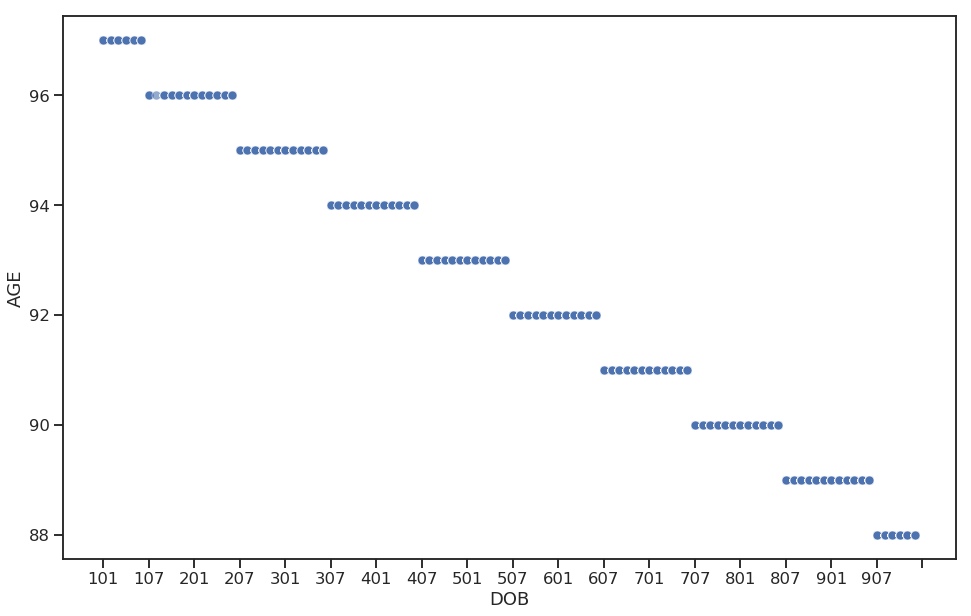

In [22]:
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (16, 10)
df = df.sort_values(by="DOB")
g = sns.scatterplot(x="DOB", y="AGE", data=df, alpha=0.6)

tick_spacing=6
g.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
g

In [23]:
def fix_format(d):
    if not pd.isna(d):
        if len(d) == 3:
            d = '0'+d
    return d

learning_raw["data"][dh.DATE_FEATURES] = learning_raw["data"].loc[:,dh.DATE_FEATURES].applymap(fix_format)

### Zip codes

Zip codes are expected to be integers. From the object dtype, it is obvious that there are other characters present.

In [24]:
learning_raw["data"].ZIP.describe()

count     95412
unique    19938
top       85351
freq         61
Name: ZIP, dtype: object

Several zip codes have trailing dashes. These are removed. They most likely are remainders from the zip+4 format, where each zip code has another level added for finer resolution codes.

In [25]:
learning_raw["data"].loc[learning_raw["data"].ZIP.map(lambda z: str(z)[-1] == "-"),"ZIP"]

CONTROLN
49909     37127-
160963    93527-
82335     55066-
86352     57783-
106585    68061-
31911     23005-
111234    65473-
187266    34761-
93567     60625-
159662    95817-
144189    90302-
28682     28025-
174306    97219-
179928    98125-
93495     60631-
131008    80537-
84658     55918-
622       94040-
189749    33437-
191411    68017-
45562     33761-
190951    60429-
104388    66043-
107630    68847-
58508     42206-
23351     29360-
85083     55044-
174484    97042-
132724    55009-
150702    92359-
           ...  
1479      92545-
118393    75703-
13106     85029-
91043     60426-
72578     60084-
11967     29673-
110959    71743-
85022     56114-
169983    95452-
7197      32810-
183964    99218-
168294    92870-
64282     47846-
112997    73018-
187264    27612-
13274     49920-
182617    98548-
65602     48207-
82570     55076-
145074    90291-
176152    97303-
159553    99206-
97830     62237-
23779     29464-
177994    97826-
133721    83703-
159973    93308-
16402

In [26]:
# Fix formatting for ZIP feature
learning_raw["data"].ZIP = learning_raw["data"].ZIP.str.replace(
    '-', '').replace([' ', '.'], np.nan).astype('int64')

### Features for MDMAUD
The major donor matrix, a multi-byte feature, is already provided split into MDMAUD_R, MDMAUD_F and MDMAUD_A. As per the documentation, X is used as NA code. We now coerce X to np.nan

In [27]:
learning_raw["data"][['MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']] = learning_raw["data"].loc[:, ['MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']].replace('X', np.nan)

### RFA features
RFA stands for Recency, Frequency, Amount and denotes an example's status as per a given past mailing.
The features are multibyte categoricals, each byte denoting either R, F or A. Entries that are not 3 bytes long are set to np.nan because they're invalid.

In [28]:
def is_invalid_rfa(v):
    if not pd.isna(v):
        return False if len(str(v)) == 3 else True

In [29]:
learning_raw["data"].loc[:, dh.NOMINAL_FEATURES[2:]].applymap(is_invalid_rfa).sum()

RFA_2      0.0
RFA_3      0.0
RFA_4      0.0
RFA_5      0.0
RFA_6      0.0
RFA_7      0.0
RFA_8      0.0
RFA_9      0.0
RFA_10     0.0
RFA_11     0.0
RFA_12     0.0
RFA_13     0.0
RFA_14     0.0
RFA_15     0.0
RFA_16     0.0
RFA_17     0.0
RFA_18     0.0
RFA_19     0.0
RFA_20     0.0
RFA_21     0.0
RFA_22     0.0
RFA_23    22.0
RFA_24     0.0
dtype: float64

In [30]:
def validate_value(v):
        if not pd.isna(v):
            if not len(v) == 3:
                v = np.nan
        return v

In [31]:
learning_raw["data"][dh.NOMINAL_FEATURES[2:]] = learning_raw["data"].loc[:, dh.NOMINAL_FEATURES[2:]].applymap(validate_value)

### Sanitizing Feature RAMNT
RAMNT denotes the amount received for a past mailing. We check all NaN RAMNT_* values against the corresponding RDATE_* value. If there is a RDATE_* value for a certain NaN- RAMNT_*, then this is strong evidence that the value is actually missing. If there is no date set, then most likely the example really has not donated and we can set the value to zero.

In [32]:
def really_missing(example):
    ramnt = None
    if pd.isna(example[0]):
        ramnt = 0 if pd.isna(example[1]) else np.nan
    else:
        ramnt = example[0]
    return ramnt

In [33]:
for i in range(3, 25):
    X_temp = learning_raw["data"][["RAMNT_" + str(i), "RDATE_" + str(i)]]
    learning_raw["data"]["RAMNT_" + str(i)] = X_temp.agg(really_missing, axis=1)

### Binary features

For these, we will convert the values specified as True and False in the dataset dictionary into 1 and 0 respectively. Furthermore, input errors are also being treated. In the end, these features will be of dtype Int64, having {1, 0 and NaN} as values.

For features that either have a value representing True or are empty (as specified in the dataset dictionary), all empty cells will be considered False. For features specifically denoting True and False values, these will be coded appropriately and empty cells set to NaN.

#### Feature NOEXCH

As per the documentation, NOEXCH should be a binary feature, encoded 1/0. Several examples have an X instead of a 1 for True. This is fixed here:

In [34]:
learning_raw["data"].NOEXCH.unique()

array(['0', '1', 'X', nan], dtype=object)

In [35]:
learning_raw["data"].NOEXCH = learning_raw["data"].NOEXCH.str.replace("X", "1")

In [36]:
learning_raw["data"][dh.BINARY_FEATURES].describe().transpose()

,count,unique,top,freq
MAILCODE,95412,2,,94013
NOEXCH,95405,2,0,95085
RECSWEEP,95412,2,,93795
RECINHSE,95412,2,,88709
RECP3,95412,2,,93395
RECPGVG,95412,2,,95298
AGEFLAG,65864,2,E,57344
HOMEOWNR,73184,2,H,52354
MAJOR,95412,2,,95118
COLLECT1,95412,2,,90210


In [37]:
binary_transformer = ColumnTransformer(
    [("binary_x_bl",
      BinaryFeatureRecode(
          value_map={
              "true": "X",
              "false": " "
          }, correct_noisy=False),
      ["PEPSTRFL", "MAJOR", "RECINHSE", "RECP3", "RECPGVG", "RECSWEEP"]),
     ("binary_y_blank",
      BinaryFeatureRecode(
          value_map={
              "true": "Y",
              "false": " "
          }, correct_noisy=False), [
              "COLLECT1", "VETERANS", "BIBLE", "CATLG", "HOMEE", "PETS",
              "CDPLAY", "STEREO", "PCOWNERS", "PHOTO", "CRAFTS", "FISHER",
              "GARDENIN", "BOATS", "WALKER", "KIDSTUFF", "CARDS", "PLATES"
          ]),
     ("binary_e_i",
      BinaryFeatureRecode(
          value_map={
              "true": "E",
              "false": "I"
          }, correct_noisy=False), ["AGEFLAG"]),
     ("binary_h_u",
      BinaryFeatureRecode(
          value_map={
              "true": "H",
              "false": "U"
          }, correct_noisy=False), ["HOMEOWNR"]),
     ("binary_b_bl",
      BinaryFeatureRecode(
          value_map={
              "true": "B",
              "false": " "
          }, correct_noisy=False), ["MAILCODE"]),
     ("binary_1_0",
      BinaryFeatureRecode(
          value_map={
              "true": "1",
              "false": "0"
          }, correct_noisy=False), ["HPHONE_D", "NOEXCH"])])

In [38]:
binaries = binary_transformer.fit_transform(learning_raw["data"])
binary_names = [n[n.find('__')+2:]
                 for n in binary_transformer.get_feature_names()]
binaries = pd.DataFrame(data=binaries, columns=binary_names, index=learning_raw["data"].index)

In [39]:
learning_raw["data"][binary_names] = binaries

In [40]:
learning_raw["data"][binary_names] = learning_raw["data"][binary_names].astype("Int64")
learning_raw["data"][binary_names]

,PEPSTRFL,MAJOR,RECINHSE,RECP3,RECPGVG,RECSWEEP,COLLECT1,VETERANS,BIBLE,CATLG,...,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,AGEFLAG,HOMEOWNR,MAILCODE,HPHONE_D,NOEXCH
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,0,0,0
148535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15078,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,1,0
172556,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
7112,0,0,1,1,0,0,0,0,1,1,...,0,1,0,1,0,1,1,0,1,0
47784,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,0,0,0
62117,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
109359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,1,0
75768,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,NaN,0,0,1,0


### Splitting multibyte features
Multibyte features are categoricals where each byte represents one feature. These are split here.

In [41]:
multibyte_transformer = ColumnTransformer(
    [("spread_rfa", MultiByteExtract(["R", "F", "A"]), dh.NOMINAL_FEATURES[3:]),
     ("spread_domain", MultiByteExtract(["Urbanicity", "SocioEconomic"]),
      ["DOMAIN"])])

In [42]:
multibytes = multibyte_transformer.fit_transform(learning_raw["data"])
multibytes_names = [n[n.find('__')+2:]
                 for n in multibyte_transformer.get_feature_names()]

Merge learning and the new nominal features, then drop the originals

In [43]:
multibytes = pd.DataFrame(data=multibytes, columns=multibytes_names,
                   index=learning_raw["data"].index).astype("category")
learning_raw["data"] = learning_raw["data"].merge(multibytes, on=learning_raw["data"].index.name)

In [44]:
learning_raw["data"].filter(regex=r"RFA_*").columns

Index(['RFA_2', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9',
       'RFA_10', 'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16',
       'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23',
       'RFA_24', 'RFA_2R', 'RFA_2F', 'RFA_2A', 'RFA_3R', 'RFA_3F', 'RFA_3A',
       'RFA_4R', 'RFA_4F', 'RFA_4A', 'RFA_5R', 'RFA_5F', 'RFA_5A', 'RFA_6R',
       'RFA_6F', 'RFA_6A', 'RFA_7R', 'RFA_7F', 'RFA_7A', 'RFA_8R', 'RFA_8F',
       'RFA_8A', 'RFA_9R', 'RFA_9F', 'RFA_9A', 'RFA_10R', 'RFA_10F', 'RFA_10A',
       'RFA_11R', 'RFA_11F', 'RFA_11A', 'RFA_12R', 'RFA_12F', 'RFA_12A',
       'RFA_13R', 'RFA_13F', 'RFA_13A', 'RFA_14R', 'RFA_14F', 'RFA_14A',
       'RFA_15R', 'RFA_15F', 'RFA_15A', 'RFA_16R', 'RFA_16F', 'RFA_16A',
       'RFA_17R', 'RFA_17F', 'RFA_17A', 'RFA_18R', 'RFA_18F', 'RFA_18A',
       'RFA_19R', 'RFA_19F', 'RFA_19A', 'RFA_20R', 'RFA_20F', 'RFA_20A',
       'RFA_21R', 'RFA_21F', 'RFA_21A', 'RFA_22R', 'RFA_22F', 'RFA_22A',
       'RFA_23R', 

In [45]:
learning_raw["data"].drop(dh.NOMINAL_FEATURES[2:]+["DOMAIN"], axis=1, inplace=True)

### Categorical features

#### Ordinal

Several ordinal features are present. We need to ensure to encode the levels correctly. The mappings are provided in the dataset documentation.

In [46]:
ordinal_transformer = ColumnTransformer(
    [("order_mdmaud",
      OrdinalEncoder(
          mapping=dh.ORDINAL_MAPPING_MDMAUD, handle_missing="return_nan"),
      ["MDMAUD_R", "MDMAUD_A"]),
     ("order_rfa",
      OrdinalEncoder(
          mapping=dh.ORDINAL_MAPPING_RFA,
          handle_missing="return_nan",
          handle_unknown="return_nan"),
      ["RFA_" + str(i) + "A" for i in range(2, 25)]),
     ("recode_socioecon",
      OrdinalEncoder(
          mapping=dh.ORDINAL_MAPPING_SOCIOECON,
          handle_missing="return_nan",
          handle_unknown="return_nan"), ["DOMAINSocioEconomic"]),
     ("order_remaining", OrdinalEncoder(handle_missing="return_nan"),
      ["WEALTH1", "WEALTH2", "INCOME", "MDMAUD_F"
       ] + ["RFA_" + str(i) + "F" for i in range(2, 25)])])

In [47]:
ordinals = ordinal_transformer.fit_transform(learning_raw["data"])

In [48]:
ordinal_names = [n[n.find('__')+2:]
                 for n in ordinal_transformer.get_feature_names()]

In [49]:
ordinals = pd.DataFrame(data=ordinals, columns=ordinal_names,
                   index=learning_raw["data"].index).astype("category")
learning_raw["data"][ordinal_names] = ordinals

When the order is obvious, no order has to be passed in (i.e. 0 < 1 < 2 < 3 < ... and alphabetical). Some of these categories are encoded float, so nonetheless, we pass them through the ordinal encoder to obtain well-formatted data

In [50]:
learning_raw["data"]["WEALTH1"].cat.categories

Float64Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype='float64')

In [51]:
rem_ords = ColumnTransformer([("order_remaining",
                               OrdinalEncoder(handle_missing="return_nan"),
                               ["WEALTH1", "WEALTH2", "INCOME", "MDMAUD_F"] +
                               ["RFA_" + str(i) + "F" for i in range(2, 25)])])
ordinals_numeric = rem_ords.fit_transform(learning_raw["data"])

In [52]:
num_ord_names = rem_ords.get_feature_names()
ordinals_numeric = pd.DataFrame(data=ordinals_numeric, index=learning_raw["data"].index,columns = num_ord_names)
learning_raw["data"][num_ord_names] = ordinals_numeric

### Low variance (constant) and sparse feature removal

The approach to removing near-zero variance features is borrowed from R's caret package.

The beauty of the method is that it is data type agnostic. It works on the number of unique values per feature and the frequency ratio between the top and second values by count.

Sparse features are those which only hold a low number of non-NA values. The threshold was set to 10%, meaning that every feature with less than 10% of non-NA values will be removed.

In [53]:
zv = ZeroVarianceSparseDropper(override=['TARGET_B', 'TARGET_D'])
_ = zv.fit_transform(learning_raw["data"]) # returns a dataframe with the features removed, but we discard it here
learning_raw["data"] = learning_raw["data"].drop(zv._dropped, axis=1) # zv._dropped has a list of the features that are either near-zero variance or below the sparsity threshold

### Cleaning put together
The operations shown above are bundled together in `data_provider.Cleaner.preprocess()`.

In [54]:
learning_cleaned = data_provider.cleaned_data